In [2]:
import sys
import numpy as np
from collections import deque
from gym.spaces.discrete import Discrete
from gym_sokoban.envs import SokobanEnv
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class SokobanEnvFixated(SokobanEnv): 
    def __init__(self):
        SokobanEnv.__init__(self,
                            dim_room=(10, 10), 
                            max_steps=40, 
                            num_boxes=4, 
                            num_gen_steps=None, 
                            reset=True)
        self.action_space = Discrete(5) # limit to push actions

    def reset(self, second_player=False, render_mode='rgb_array'):

        self.room_fixed = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                    [0, 0, 0, 1, 1, 0, 1, 0, 0, 0],
                                    [0, 1, 1, 1, 1, 2, 1, 1, 1, 0],
                                    [0, 1, 1, 1, 2, 1, 1, 1, 1, 0],
                                    [0, 1, 1, 1, 0, 1, 1, 2, 1, 0],
                                    [0, 2, 1, 0, 0, 0, 0, 0, 0, 0],
                                    [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
                                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
        self.room_state = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                    [0, 0, 0, 1, 1, 0, 1, 0, 0, 0],
                                    [0, 1, 1, 4, 5, 2, 1, 1, 1, 0],
                                    [0, 1, 1, 1, 2, 4, 1, 4, 1, 0],
                                    [0, 1, 1, 1, 0, 1, 1, 2, 1, 0],
                                    [0, 2, 4, 0, 0, 0, 0, 0, 0, 0],
                                    [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
                                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
        self.box_mapping = {(6, 7): (5, 7), (5, 4): (5, 5), (4, 5): (4, 3), (7, 1): (7, 2)}

        self.player_position = np.argwhere(self.room_state == 5)[0]
        self.num_env_steps = 0
        self.reward_last = 0
        self.boxes_on_target = 0

        starting_observation = self.render(render_mode)
        return starting_observation # Close environment after testing

def render_state(env, mode="rgb_array"):
    """Renders the Sokoban environment as image and displays it."""
    image = env.render(mode)

    plt.figure(dpi=200) 
    plt.imshow(image)
    plt.axis('off')
    plt.show()

Actions: → → → ↓ ← ← ← ← ↓ ← ← ↓ ↓ → ↑ ← ↑ ↑ → → ↓ ← ↑ ← ↓ ↑ ↑ → → → 	 Total: 30


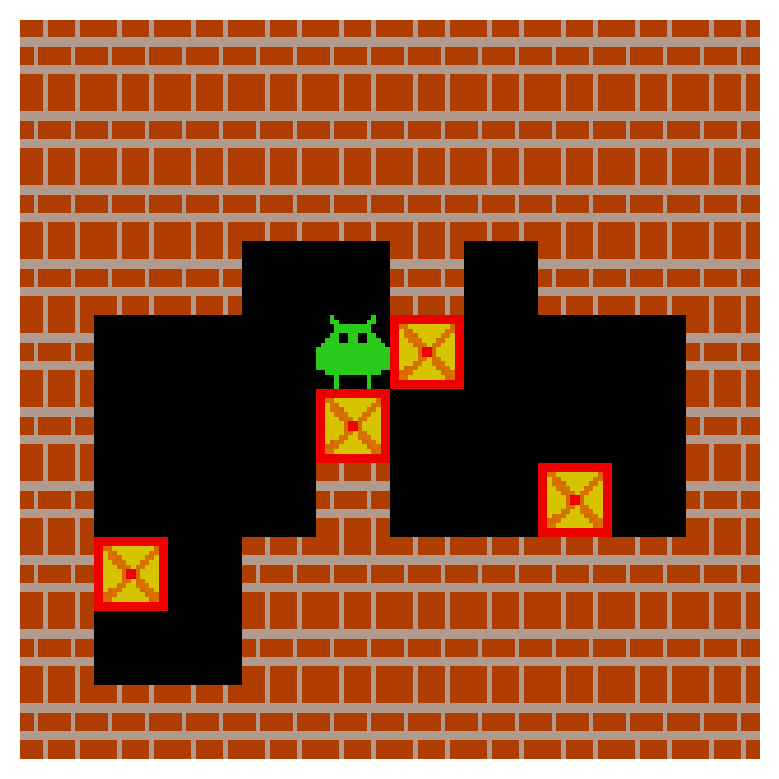

In [18]:
UP, DOWN, LEFT, RIGHT = 1, 2, 3, 4
actionDict = {0:"□", 1:"↑", 2:"↓", 3:"←", 4:"→"}

def breadth_first_search(room_fixed, room_state):
    # Find initial player position and boxes
    player_pos = None
    boxes = set()
    rows, cols = room_state.shape
    for i in range(rows):
        for j in range(cols):
            if room_state[i][j] == 5:
                player_pos = (i, j)
            elif room_state[i][j] == 4:
                boxes.add((i, j))
    if player_pos is None:
        return None  # No player found
    
    # Convert boxes to a sorted tuple for consistent state representation
    initial_boxes = tuple(sorted(boxes))
    
    # Find all button positions from room_fixed
    buttons = set(zip(*np.where(room_fixed == 2)))
    
    # Check if already solved
    if set(initial_boxes) >= buttons:
        return []
    
    # Directions: (delta_row, delta_col, move_char)
    directions = [(-1, 0, UP), (1, 0, DOWN), (0, -1, LEFT), (0, 1, RIGHT)]
    
    # BFS initialization
    visited = set()
    queue = deque()
    initial_state = (player_pos, initial_boxes)
    queue.append((player_pos, initial_boxes, []))
    visited.add((player_pos, initial_boxes))
    
    while queue:
        current_pos, current_boxes, path = queue.popleft()
        
        # Check if all buttons are covered
        if set(current_boxes) >= buttons:
            return path
        
        for dx, dy, move in directions:
            new_x = current_pos[0] + dx
            new_y = current_pos[1] + dy
            
            # Check if new position is within bounds and not a wall
            if 0 <= new_x < rows and 0 <= new_y < cols:
                if room_fixed[new_x][new_y] == 0:
                    continue  # Wall, cannot move here
                
                # Check if the new position is a box
                if (new_x, new_y) in current_boxes:
                    # Calculate new box position
                    box_new_x = new_x + dx
                    box_new_y = new_y + dy
                    
                    # Check if new box position is valid
                    if 0 <= box_new_x < rows and 0 <= box_new_y < cols:
                        if room_fixed[box_new_x][box_new_y] != 0 and (box_new_x, box_new_y) not in current_boxes:
                            # Create new boxes tuple
                            new_boxes_list = list(current_boxes)
                            new_boxes_list.remove((new_x, new_y))
                            new_boxes_list.append((box_new_x, box_new_y))
                            new_boxes = tuple(sorted(new_boxes_list))
                            
                            # New player position is (new_x, new_y)
                            new_pos = (new_x, new_y)
                            
                            # Check if this state has been visited
                            state_key = (new_pos, new_boxes)
                            if state_key not in visited:
                                visited.add(state_key)
                                queue.append((new_pos, new_boxes, path + [move]))
                else:
                    # Move to empty space
                    new_pos = (new_x, new_y)
                    state_key = (new_pos, current_boxes)
                    if state_key not in visited:
                        visited.add(state_key)
                        queue.append((new_pos, current_boxes, path + [move]))
    
    # No solution found
    return None

env = SokobanEnvFixated()
actions = breadth_first_search(env.room_fixed, env.room_state)
print("Actions:", " ".join(actionDict.get(action) for action in actions), "\t Total:", len(actions))

# Test actions
for action in actions:
    env.step(action)
render_state(env)